In [148]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [149]:
# Загрузка данных
data = pd.read_csv("SBER_240101_240430.csv", delimiter=";")
data.drop(columns=['<PER>', '<TIME>', '<TICKER>', '<DATE>'], inplace=True)


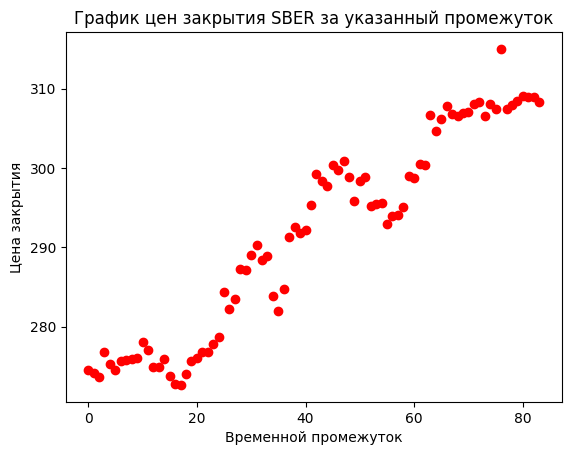

In [150]:
# График цен закрытия
plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro')
plt.xlabel("Временной промежуток")
plt.ylabel("Цена закрытия")
plt.title("График цен закрытия SBER за указанный промежуток")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                <CLOSE>   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     990.8
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.50e-47
Time:                        13:46:33   Log-Likelihood:                -224.50
No. Observations:                  84   AIC:                             453.0
Df Residuals:                      82   BIC:                             457.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        270.7838      0.767    353.097      0.0

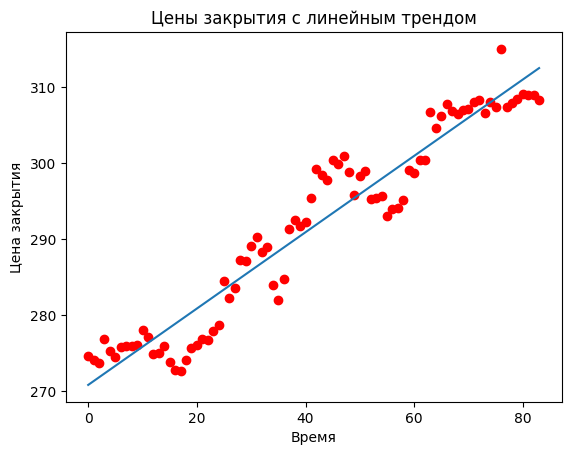

In [151]:

# Линейная регрессия
time = np.array([i for i in range(len(data))])
X = np.array([i for i in range(len(data))]).reshape(-1, 1)
y = data['<CLOSE>']

# Модель линейной регрессии
X_with_const = sm.add_constant(X)
sm_model = sm.OLS(y, X_with_const).fit()
print(sm_model.summary())

# Построение тренда
model_params = np.array(sm_model.params)
plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro',
         [i for i in range(len(data))], [(i * model_params[1] + model_params[0]) for i in range(len(data))])
plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Цены закрытия с линейным трендом")
plt.show()


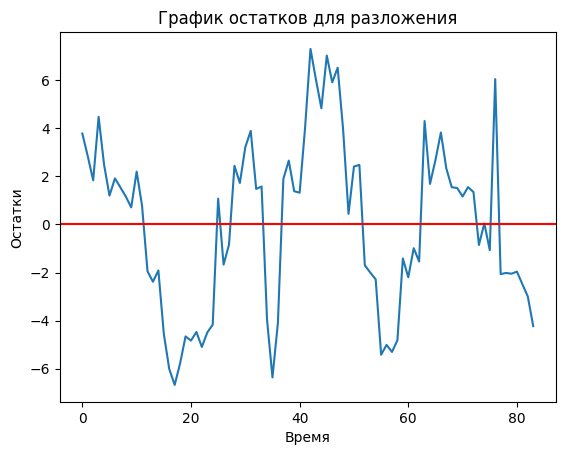

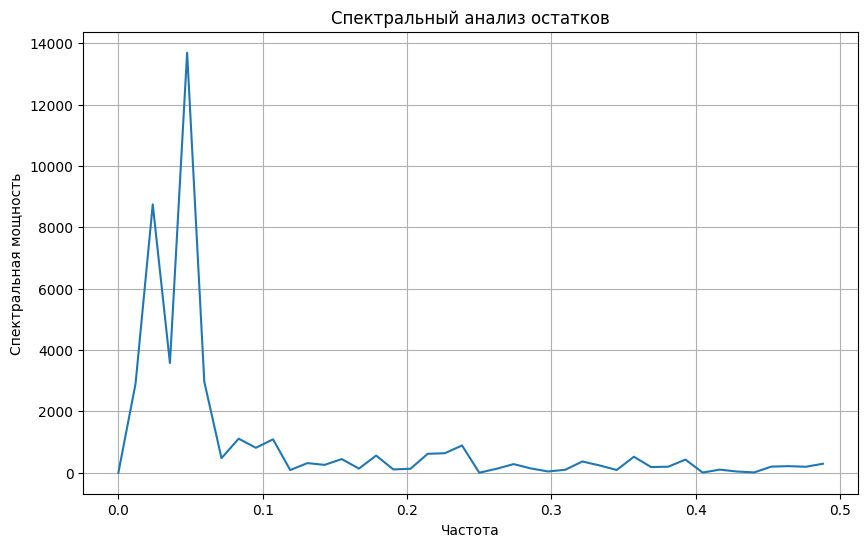

In [ ]:
# Остатки
residuals = y.to_numpy() - [(i * model_params[1] + model_params[0]) for i in range(len(data))]
plt.plot(time, residuals)
plt.axhline(0, color='red')
plt.xlabel("Время")
plt.ylabel("Остатки")
plt.title("График остатков для разложения")
plt.show()

# Дискретное преобразование Фурье для остатков
N = len(residuals)
frequencies = fftfreq(N)  # Частоты
amplitudes = fft(residuals)  # Преобразование
power = np.abs(amplitudes)**2  # Спектральная мощность

# Отображаем положительные частоты
positive_frequencies = frequencies[:N // 2]
positive_power = power[:N // 2]

# Построение спектра
plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, positive_power)
plt.title("Спектральный анализ остатков")
plt.xlabel("Частота")
plt.ylabel("Спектральная мощность")
plt.grid()
plt.show()


In [153]:
fourier_params = {}
freq_params = []

In [154]:
# Создаем копии массивов, чтобы не изменять оригинальные данные
remaining_power = positive_power.copy()
remaining_frequencies = positive_frequencies.copy()

In [155]:
# Цикл для добавления синусоидальных компонент в модель
for step in range(1, 40): 
# Находим индекс частоты с максимальной амплитудой
    top_index = np.argmax(remaining_power)
    max_frequency = remaining_frequencies[top_index]
    freq_params.append(max_frequency)

    # Удаляем использованную частоту и её амплитуду из рассмотрения
    remaining_power = np.delete(remaining_power, top_index)
    remaining_frequencies = np.delete(remaining_frequencies, top_index)

    # Формируем компоненты для текущей частоты
    cos_component = np.cos(2 * np.pi * max_frequency * time).reshape(-1, 1)
    sin_component = np.sin(2 * np.pi * max_frequency * time).reshape(-1, 1)
    X_forstep = np.hstack((cos_component,sin_component))
   
    model_cosandsin = sm.OLS(residuals,X_forstep).fit()
    print(f"Результаты модели для ряда фурье при шаге {step} и частоте {max_frequency}:")
    print(model_cosandsin.summary())

    # Проверка значимости для косинуса
    if model_cosandsin.pvalues[0] < 0.05 and model_cosandsin.pvalues[1] <0.05 and model_cosandsin.f_pvalue <0.05: 
        print(f"\nКоэф при косинусе и синусе {model_cosandsin.params}  значимы, значимость модели - {model_cosandsin.f_pvalue}")
        fourier_params.update({f"Sin{step} & Cos{step}" :model_cosandsin.params})
        residuals -= model_cosandsin.fittedvalues
    elif model_cosandsin.pvalues[0] >= 0.05 and model_cosandsin.pvalues[1] < 0.05 and model_cosandsin.f_pvalue <0.05:
        model_cosandsin = sm.OLS(residuals,sin_component).fit()
        print(model_cosandsin.summary())
        residuals -= model_cosandsin.fittedvalues
        fourier_params.update({f"Sin{step}" :model_cosandsin.params})
        print(f"\nКоэф при косинусе не значим, при синусе - значим {model_cosandsin.params}, значимость модели - {model_cosandsin.f_pvalue}")
    elif model_cosandsin.pvalues[0] < 0.05 and model_cosandsin.pvalues[1] >= 0.05 and model_cosandsin.f_pvalue <0.05:
        model_cosandsin = sm.OLS(residuals,cos_component).fit()
        fourier_params.update({f"Cos{step}" :model_cosandsin.params})
        print(f"\nКоэф при косинусе {model_cosandsin.params} значим, при синусе - незначим, значимость модели - {model_cosandsin.f_pvalue}")
        residuals -= model_cosandsin.fittedvalues
    elif model_cosandsin.pvalues[0] >= 0.05 and model_cosandsin.pvalues[1] >= 0.05 and model_cosandsin.f_pvalue < 0.05:
        print(f"Оба коэффициента на шаге {step} оказались не значимыми")
        continue
    else:
        print(f"Модель перестала быть значимой на шаге {step}")
        print(model_cosandsin.summary())
        break

Результаты модели для ряда фурье при шаге 1 и частоте 0.047619047619047616:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.316
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              18.95
Date:                Sun, 29 Dec 2024   Prob (F-statistic):                    1.71e-07
Time:                        13:46:34   Log-Likelihood:                         -208.54
No. Observations:                  84   AIC:                                      421.1
Df Residuals:                      82   BIC:                                      425.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t 

In [156]:
fourier_params

{'Sin1': array([2.77700866]),
 'Cos2': array([2.18138619]),
 'Sin3 & Cos3': array([-1.07808404,  0.92967821]),
 'Sin4': array([-1.20161803]),
 'Sin5 & Cos5': array([-0.74963429, -1.04135926]),
 'Sin6': array([0.6433004]),
 'Sin7': array([0.75750445]),
 'Cos8': array([0.70865243]),
 'Cos9': array([0.67415576]),
 'Sin10': array([0.48002254]),
 'Cos11': array([0.47001157])}

In [157]:
freq_params

[0.047619047619047616,
 0.023809523809523808,
 0.03571428571428571,
 0.05952380952380952,
 0.011904761904761904,
 0.08333333333333333,
 0.10714285714285714,
 0.23809523809523808,
 0.09523809523809523,
 0.22619047619047616,
 0.21428571428571427,
 0.17857142857142855]

In [158]:
#Итоговая модель:

In [ ]:
cos_component = np.cos(2 * np.pi * max_frequency * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_frequency * time).reshape(-1, 1)

In [159]:
model_params

array([270.78376471,   0.50223286])

In [160]:
features= []

In [161]:
for i, freq in enumerate(freq_params):
    cos_component = np.cos(2 * np.pi * freq * time)
    sin_component = np.sin(2 * np.pi * freq * time)

    # Учет параметров из fourier_params
    if f'Sin{i+1}' in fourier_params:
        features.append(fourier_params[f'Sin{i+1}'][0] * sin_component)
    if f'Cos{i+1}' in fourier_params:
        features.append(fourier_params[f'Cos{i+1}'][0] * cos_component)
    if f'Sin{i+1} & Cos{i+1}' in fourier_params:
        sin_coeff, cos_coeff = fourier_params[f'Sin{i+1} & Cos{i+1}']
        features.append(sin_coeff * sin_component + cos_coeff * cos_component)